In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread

In [3]:
def bellman_ford(m, start_vertex):
    v = Vector(m.dtype, m.nrows)
    v[start_vertex] << 0
    w = v.dup()
    for i in range(m.nrows - 1):
        w_old = w.dup()
        w(binary.min) << w.vxm(m, semiring.min_plus)
        if w.isequal(w_old):
            break
    w_old = w.dup()
    w(binary.min) << w.vxm(m, semiring.min_plus)
    if not w.isequal(w_old):
        raise Exception("Ошибка: в графе есть цикл отрицательного веса")
    ar_val = []
    for i in range(m.nrows):
        if w[i].value is None:
            ar_val.append(float('inf'))
        else:
            ar_val.append(w[i].value)
    return ar_val

In [4]:
def bellman_ford_modify(m, start_vertex_ar):
    rows = start_vertex_ar.size
    cols = m.ncols
    v = Matrix(dtypes.INT32, rows, cols)
    for i in range(rows):
        v[i, start_vertex_ar[i]] << 0
    w = v.dup()
    for i in range(cols - 1):
        w_old = w.dup()
        for i in range(rows):
            w[i, :](binary.min) << w[i, :].vxm(m, semiring.min_plus)
        if w.isequal(w_old):
            break
    w_old = w.dup()
    for i in range(rows):
        w[i, :](binary.min) << w[i, :].vxm(m, semiring.min_plus)
    if not w.isequal(w_old):
        raise Exception("Ошибка: в графе есть цикл отрицательного веса")
    output = {}
    for i in range(rows):
        ar_val = []
        for j in range(cols):
            if w[i, j].value is None:
                ar_val.append(float('inf'))
            else:
                ar_val.append(w[i, j].value)
        output[start_vertex_ar[i]] = np.array(ar_val)
    return output

In [5]:
def floyd_warshall(m):
    D = m.dup()
    rows = m.nrows
    cur_D = m.dup()
    for k in range(rows):
        D_col = Matrix(dtypes.INT32, rows, rows)
        D_row = Matrix(dtypes.INT32, rows, rows)
        D_col[:, k] = D[:, k].dup()
        D_row[k, :] = D[k, :].dup()
        cur_D << D_col.mxm(D_row, semiring.min_plus)
        D << D.ewise_add(cur_D, op="min")
    D1 = D.dup()
    cur_D1 = cur_D.dup()
    D_col1 = Matrix(dtypes.INT32, rows, rows)
    D_row1 = Matrix(dtypes.INT32, rows, rows)
    D_col1[:, k] = D1[:, k].dup()
    D_row1[k, :] = D1[k, :].dup()
    cur_D1 << D_col1.mxm(D_row1, semiring.min_plus)
    D1 << D1.ewise_add(cur_D1, op="min")
    if not D1.isequal(D):
        raise Exception("Ошибка: в графе есть цикл отрицательного веса")
    output = {}
    for i in range(rows):
        ar_val = []
        for j in range(rows):
            if i == j:
                ar_val.append(0)
            elif D[i, j].value is None:
                ar_val.append(float('inf'))
            else:
                ar_val.append(D[i, j].value)
        output[i] = np.array(ar_val)
    return output

In [6]:
def transitive_closure(m):
    rows = m.nrows
    I = Matrix(dtypes.INT32, rows, rows)
    for i in range(rows):
        I[i, i] << 1
    D = I.dup()
    for i in range(rows):
        D1 = D.dup()
        D = D.mxm(m, semiring.min_plus).ewise_add(I, op="min")
        if D1.isequal(D):
            break
    D2 = D.dup()
    D2 = D2.mxm(m, semiring.min_plus).ewise_add(I, op="min")
    if not D2.isequal(D):
        raise Exception("Ошибка: в графе есть цикл отрицательного веса")
    # формирую ответ
    output = {}
    for i in range(rows):
        ar_val = []
        for j in range(rows):
            if D[i, j].value is None:
                ar_val.append(float('inf'))
            elif i == j:
                ar_val.append(0)
            else:
                ar_val.append(D[i, j].value - 1)
        output[i] = np.array(ar_val)
    return output


**Тесты для проверки корректности полученных реализаций**

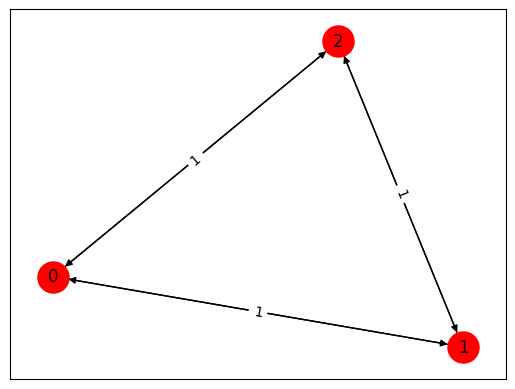

In [7]:
M1 = gb.Matrix.from_coo(
    [0, 0, 1, 1, 2, 2],
    [1, 2, 0, 2, 0, 1],
    [1, 1, 1, 1, 1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M1)

При старте в вершине 0 результатом работы функции `bellman_ford` будет массив [0, 1, 1]

In [17]:
bellman_ford(M1, 0)

[0, 1, 1]

Для функций `bellman_ford_modify`, `floyd_warshall` и `transitive_closure` результатом работу будут кортежи, которые содержат стартовую вершину и список уровней для всех вершин графа
1. Для старта в вершине 0 - (0, [0, 1, 1])
1. Для старта в вершине 1 - (0, [1, 0, 1])
1. Для старта в вершине 2 - (0, [1, 1, 0])

In [19]:
bellman_ford_modify(M1, np.array([0, 1, 2]))

{0: array([0, 1, 1]), 1: array([1, 0, 1]), 2: array([1, 1, 0])}

In [20]:
floyd_warshall(M1)

{0: array([0, 1, 1]), 1: array([1, 0, 1]), 2: array([1, 1, 0])}

In [21]:
transitive_closure(M1)

{0: array([0, 1, 1]), 1: array([1, 0, 1]), 2: array([1, 1, 0])}

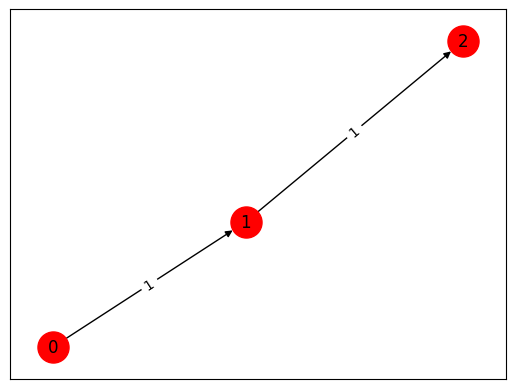

In [12]:
M2 = gb.Matrix.from_coo(
    [0, 1],
    [1, 2],
    [1, 1],
    nrows=3,
    ncols=3
)
gb.viz.draw(M2)

При старте в вершине 0 результатом работы функции `bellman_ford` будет массив [0, 1, 2].

In [23]:
bellman_ford(M2, 0)

[0, 1, 2]

Для функций `bellman_ford_modify`, `floyd_warshall` и `transitive_closure` результатом работу будут:
1. Для старта в вершине 0 - (0, [0, 1, 2])
1. Для старта в вершине 1 - (0, [inf, 0, 1])
1. Для старта в вершине 2 - (0, [inf, inf, 0])

inf - вершина недостижима из  старта

In [24]:
bellman_ford_modify(M2, np.array([0, 1, 2]))

{0: array([0, 1, 2]), 1: array([inf,  0.,  1.]), 2: array([inf, inf,  0.])}

In [25]:
floyd_warshall(M2)

{0: array([0, 1, 2]), 1: array([inf,  0.,  1.]), 2: array([inf, inf,  0.])}

In [26]:
transitive_closure(M2)

{0: array([0, 1, 2]), 1: array([inf,  0.,  1.]), 2: array([inf, inf,  0.])}